Le dataset contient les données de consommation d'électricité (pic de consommation journalier) en France ainsi que les données journalières de température.

Le but de cette analyse prédictive est de prédire la consommation d'électricité (pic de consommation journalier) entre 2021 et 2023 grâce à un modèle de machine learning qu'on aura au préalable entraîné sur les données allant de 2012 à 2020.

Nous allons utiliser un modèle RandomForest (Forêts aléatoires).

Le principe d'une forêt aléatoire est tout simplement de générer un grand nombre d'arbres de décisions qui seront ensuite combinés (en utilisant des moyennes ou des règles de "majorité") à la fin du processus.

Grâce à cela, si par exemple à un instant t en 2023, on a les prédictions météo (température) sur une certaine plage temporelle, on pourra utiliser ce modèle pour prédire la consommation d'électricité sur cette plage temporelle.

Importation des librairies

In [87]:
import pyodbc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

Importation du jeu de données et création du dataframe Pandas

In [88]:
df = pd.read_csv('pic-journalier-consommation-brute.csv', sep=';')
df

,Date,Pic journalier consommation (MW),Température moyenne (°C),Température référence (°C)
0,2012-01-01,59610.0,11.7,4.6
1,2012-01-04,78337.0,8.1,4.6
2,2012-01-13,78700.0,5.3,4.8
3,2012-01-14,74666.0,2.4,4.8
4,2012-01-19,80026.0,8.4,5.0
...,...,...,...,...
4072,2023-01-27,78756.0,3.4,5.3
4073,2023-01-30,78703.0,4.0,5.5
4074,2023-02-05,62951.0,7.2,5.8
4075,2023-02-10,78126.0,3.9,6.1


Création des champs annee, mois et jour

In [89]:
# conversion la colonne 'Date' en un objet DateTime
df['Date'] = pd.to_datetime(df['Date'])

# extraire l'année, le mois et le jour et créer des colonnes distinctes
df['annee'] = df['Date'].dt.year
df['mois'] = df['Date'].dt.month
df['jour'] = df['Date'].dt.day

# afficher le dataframe mis à jour
df


,Date,Pic journalier consommation (MW),Température moyenne (°C),Température référence (°C),annee,mois,jour
0,2012-01-01,59610.0,11.7,4.6,2012,1,1
1,2012-01-04,78337.0,8.1,4.6,2012,1,4
2,2012-01-13,78700.0,5.3,4.8,2012,1,13
3,2012-01-14,74666.0,2.4,4.8,2012,1,14
4,2012-01-19,80026.0,8.4,5.0,2012,1,19
...,...,...,...,...,...,...,...
4072,2023-01-27,78756.0,3.4,5.3,2023,1,27
4073,2023-01-30,78703.0,4.0,5.5,2023,1,30
4074,2023-02-05,62951.0,7.2,5.8,2023,2,5
4075,2023-02-10,78126.0,3.9,6.1,2023,2,10


Structure du dataframe

In [90]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4077 entries, 0 to 4076
Data columns (total 7 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   Date                              4077 non-null   datetime64[ns]
 1   Pic journalier consommation (MW)  4077 non-null   float64       
 2   Température moyenne (°C)          4077 non-null   float64       
 3   Température référence (°C)        4077 non-null   float64       
 4   annee                             4077 non-null   int64         
 5   mois                              4077 non-null   int64         
 6   jour                              4077 non-null   int64         
dtypes: datetime64[ns](1), float64(3), int64(3)
memory usage: 223.1 KB


Dans la suite, nous chercherons à prédire la valeur du champ "<span style="font-size:12px;white-space:pre-wrap;">Pic journalier consommation (MW)</span>" en fonction de la température et de la date.

Nous utiliserons pour cela un modèle RandomForest (Forêts aléatoires).

Préparation du dataframe pour le machine learning

Sélection des champs qui seront utilisés dans la suite

In [91]:
df = df[["annee","mois","jour","Température moyenne (°C)","Température référence (°C)","Pic journalier consommation (MW)"]]

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4077 entries, 0 to 4076
Data columns (total 6 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   annee                             4077 non-null   int64  
 1   mois                              4077 non-null   int64  
 2   jour                              4077 non-null   int64  
 3   Température moyenne (°C)          4077 non-null   float64
 4   Température référence (°C)        4077 non-null   float64
 5   Pic journalier consommation (MW)  4077 non-null   float64
dtypes: float64(3), int64(3)
memory usage: 191.2 KB


Préparation des jeux de données d'entraînement et de test. Pour le jeu d'entraînement, on prendra les données de 2012 à 2020, tandis que pour le jeu de données test, nous prendrons

les données de 2021 à 2023.

In [92]:
df_train = df[(df['annee'] >= 2012) & (df['annee'] <= 2020)]
df_test = df[(df['annee'] >= 2021)]

In [93]:
# vérification : le jeu de données d'entraînement contient bien les données de 2012 à 2020

annees_distinctes_train = df_train['annee'].unique()
annees_distinctes_train.sort()
print(annees_distinctes_train)

[2012 2013 2014 2015 2016 2017 2018 2019 2020]


In [94]:
# # vérification : le jeu de données test contient bien les données de 2021 à 2023

annees_distinctes_test = df_test['annee'].unique()
annees_distinctes_test.sort()
print(annees_distinctes_test)

[2021 2022 2023]


In [95]:
# jeu d'entraînement : il compte 3288 lignes

df_train.shape

(3288, 6)

In [96]:
# jeu de test : il compte 789 lignes

df_test.shape

(789, 6)

Initialisation du modèle de machine learning : RandomForest (Forêts aléatoires)

In [97]:
model = RandomForestRegressor(n_estimators=100, random_state=42)

Entraînement du modèle sur les données du jeu d'entraînement

In [98]:
model.fit(df_train[["annee","mois","jour","Température moyenne (°C)","Température référence (°C)"]], df_train["Pic journalier consommation (MW)"])

RandomForestRegressor(random_state=42)

Prédiction sur les données d'entraînement

In [99]:
train_data_prediction = model.predict(df_train[["annee","mois","jour","Température moyenne (°C)","Température référence (°C)"]])

Affichage du coefficient de détermination R Squared du modèle pour la prédiction sur les données d'entraînement

In [100]:
error_score = r2_score(df_train["Pic journalier consommation (MW)"], train_data_prediction)
print("R squared Error = ", error_score)

# on voit que le R squared est très élevé (proche de 1), donc la régression est très bonne.

R squared Error =  0.9817973872262719


Visualisation des pics de consommations réels et des pics de consommation prédits pour les données d'entraînement

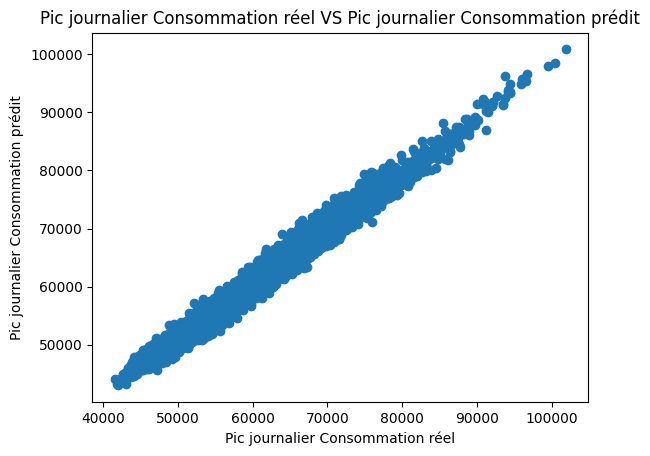

In [101]:
plt.scatter(df_train["Pic journalier consommation (MW)"], train_data_prediction)
plt.xlabel("Pic journalier Consommation réel")
plt.ylabel("Pic journalier Consommation prédit")
plt.title("Pic journalier Consommation réel VS Pic journalier Consommation prédit")
plt.show()

Prédiction sur les données de test

In [102]:
test_data_prediction = model.predict(df_test[["annee","mois","jour","Température moyenne (°C)","Température référence (°C)"]])

Affichage du coefficient de détermination R Squared du modèle pour la prédiction sur les données d'entraînement

In [103]:
error_score = r2_score(df_test["Pic journalier consommation (MW)"], test_data_prediction)
print("R squared Error = ", error_score)

# on voit que le R squared est élevé (proche de 1), donc la régression est très bonne. On a donc réussi à générer un modèle capable de prédire
# la consommation d'éléctricité entre 2023 avec de bonnes performances.

R squared Error =  0.8022536070525198


Visualisation des pics de consommations réels et des pics de consommation prédits pour les données test

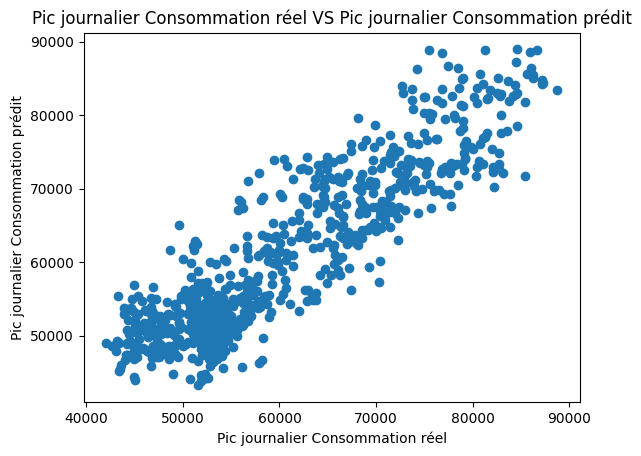

In [104]:
plt.scatter(df_test["Pic journalier consommation (MW)"], test_data_prediction)
plt.xlabel("Pic journalier Consommation réel")
plt.ylabel("Pic journalier Consommation prédit")
plt.title("Pic journalier Consommation réel VS Pic journalier Consommation prédit")
plt.show()